Import core numerical and utility functionality

In [53]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

Setup

In [54]:
np.random.seed(42)

# Vizualization settings
LARGE_FONT = 12
SMALL_FONT = 10
DPI = 400
FIG_SIZE = (10/2, 6/2)

NAME = 'assignment1'
DATA_PATH = f'data/{NAME}'
MEDIA_PATH = f'media/{NAME}'
[os.makedirs(path, exist_ok=True) for path in [DATA_PATH, MEDIA_PATH]]
print('Setup complete')

Setup complete


## Michaelis-Menten Equation

In [55]:
def michaelis_menten(substrate, km, vmax):
    return vmax * substrate / (km + substrate)

def plot_michaelis_menten(substrate_range, v, km=None, vmax=None, color='tab:blue'):
    fig = plt.figure(figsize=FIG_SIZE, dpi=DPI, layout='tight')
    plt.plot(substrate_range, v, color=color)
    plt.xlabel('Substrate concentration $[S]$')
    if vmax:
        plt.ylim(0, vmax*1.05)
        plt.yticks([0, vmax/2, vmax], ['0', '$\\frac{V_{max}}{2}$', '$V_{{max}}$'])
    plt.ylabel('Reaction rate $v$')
    plt.title(f'Michaelis-Menten kinetics')
    if km and vmax: 
        plt.legend([f'$K_m={km}, V_{{max}}={vmax}$'])
    return fig

def plot_comparison_michealis_menten(substrate_range, kms, vmaxs, colors, line_vmax=True, line_km=False):
    fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE, dpi=DPI)

    for (km, vmax, col) in zip(kms, vmaxs, colors):
        v = michaelis_menten(substrate_range, km, vmax)
        ax.plot(substrate_range, v, color=col, label=f'$K_m={km}, V_{{max}}={vmax}$', lw=2.5)
        if line_vmax:
            ax.hlines(vmax, substrate_range[0], substrate_range[-1], linestyles="dashed", color='grey')
        if line_km:
            ax.hlines(0.5 * vmax, substrate_range[0], km, linestyles="dotted", color='grey')
            ax.vlines(km, v[0], 0.5 * vmax, linestyles="dotted", color='grey')

    ax.set_ylim((0, max(vmaxs) * 1.05))
    ax.set_xlabel("Substrate concentration " + r"$[S]$")
    ax.set_ylabel("Reaction rate " + r"$v$")
    ax.legend(loc="lower right")
    ax.set_title("Michaelis-Menten kinetics comparison")
    return fig

Visualize Michaelis-Menten kinetics using the corresponding equation

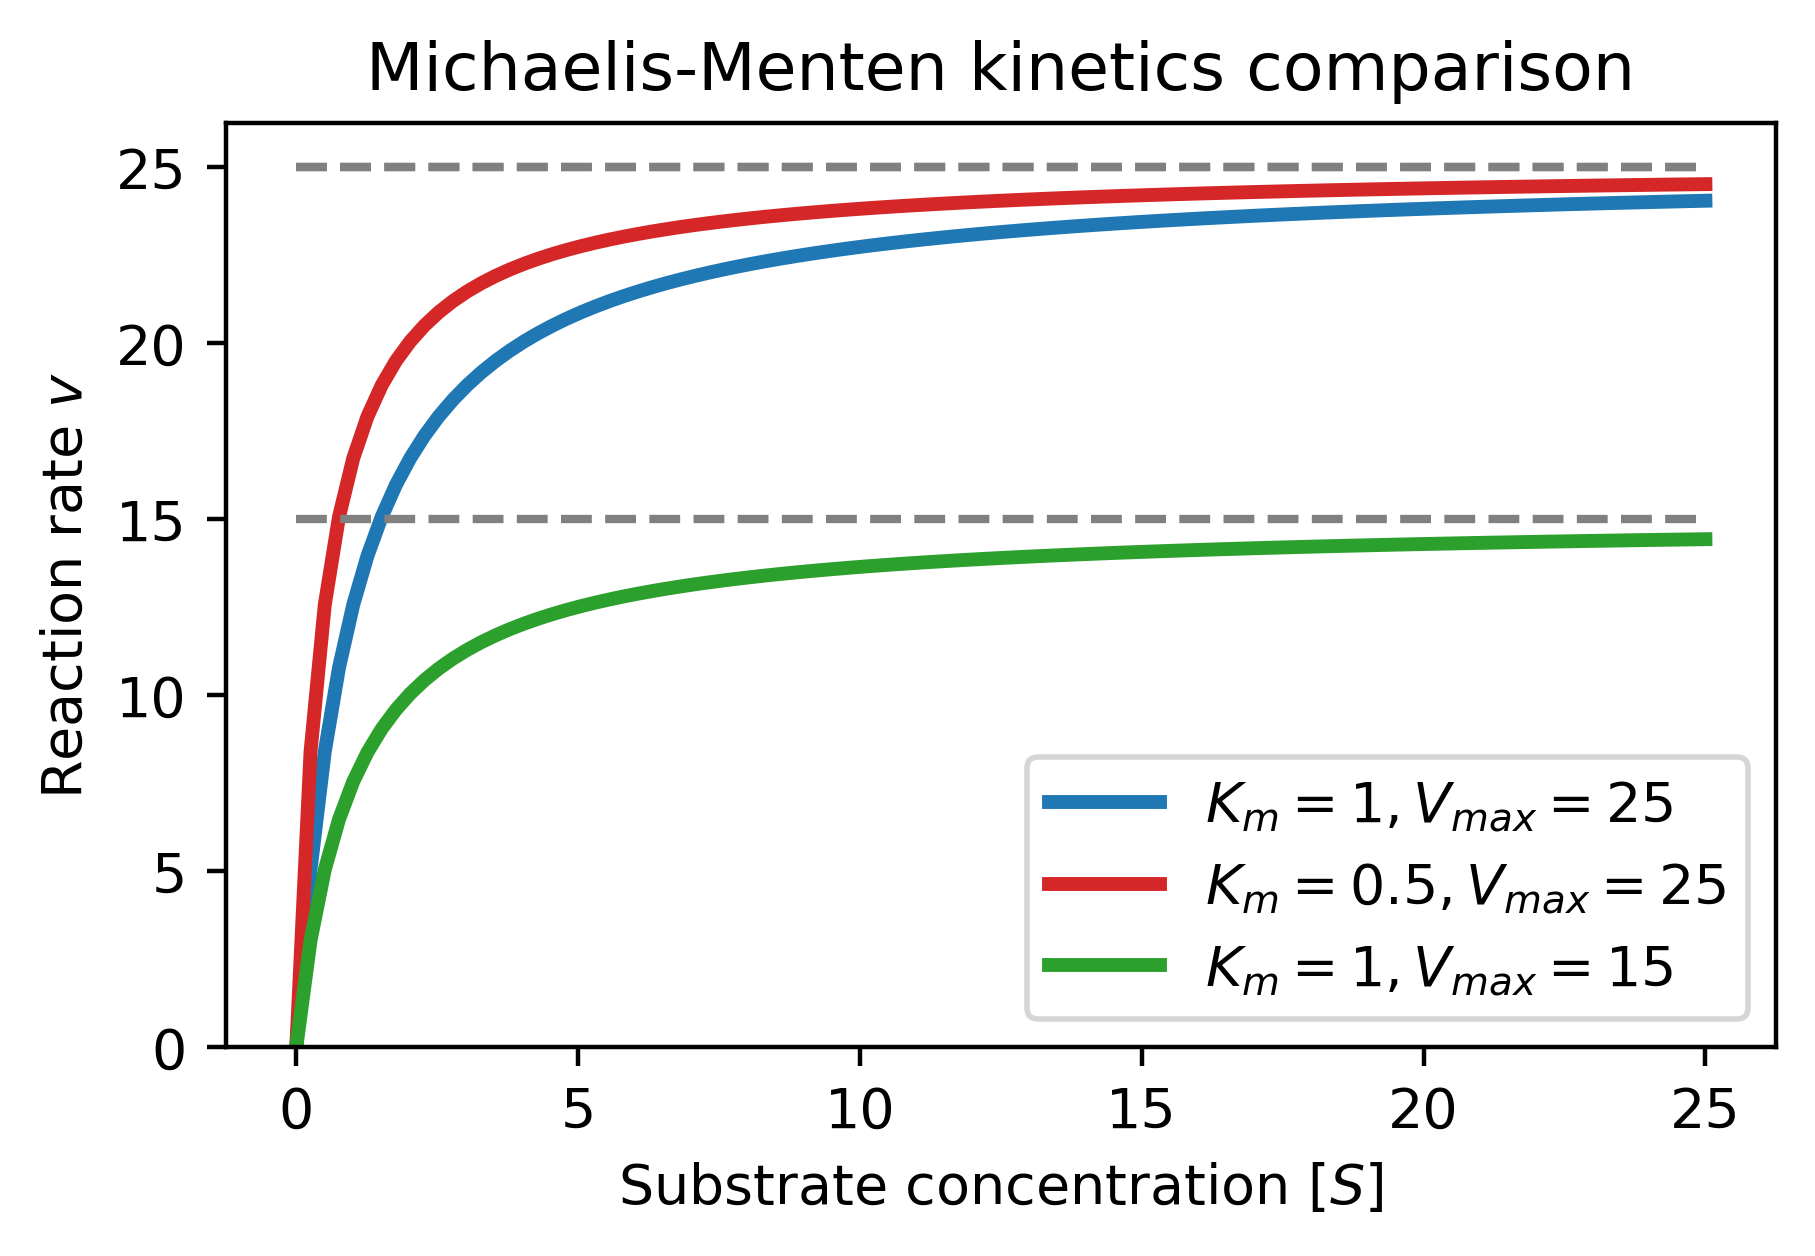

In [56]:
substrate = np.linspace(0, 25, 100)
kms = [1, 0.5, 1]
vmaxs = [25, 25, 15]
colors = ['tab:blue', 'tab:red', 'tab:green']
for km, vmax, color in zip(kms, vmaxs, colors):
    v = michaelis_menten(substrate, km, vmax)
    fig = plot_michaelis_menten(substrate, v, km, vmax, color=color)
    fig.savefig(f'{MEDIA_PATH}/michaelis_menten_km={km}_vmax={vmax}.png', bbox_inches='tight')
    plt.close(fig)
fig_comp = plot_comparison_michealis_menten(substrate, kms, vmaxs, colors)
fig_comp.savefig(f'{MEDIA_PATH}/michaelis_menten_comparison.png', bbox_inches='tight')

Visualize `measuredData.csv` dataset and fitted function

In [57]:
data = np.loadtxt("data/measuredData.csv", delimiter=",").T

ss = data[0]
vv = data[1]

In [58]:
def michaelis_menten_equation(s, vmax, km):
    return vmax * (s / (s + km))

popt, _ = curve_fit(michaelis_menten_equation, ss, vv)
vmaxopt, kmopt = popt

Estimated Vmax = 9.95
Estimated Km = 0.46


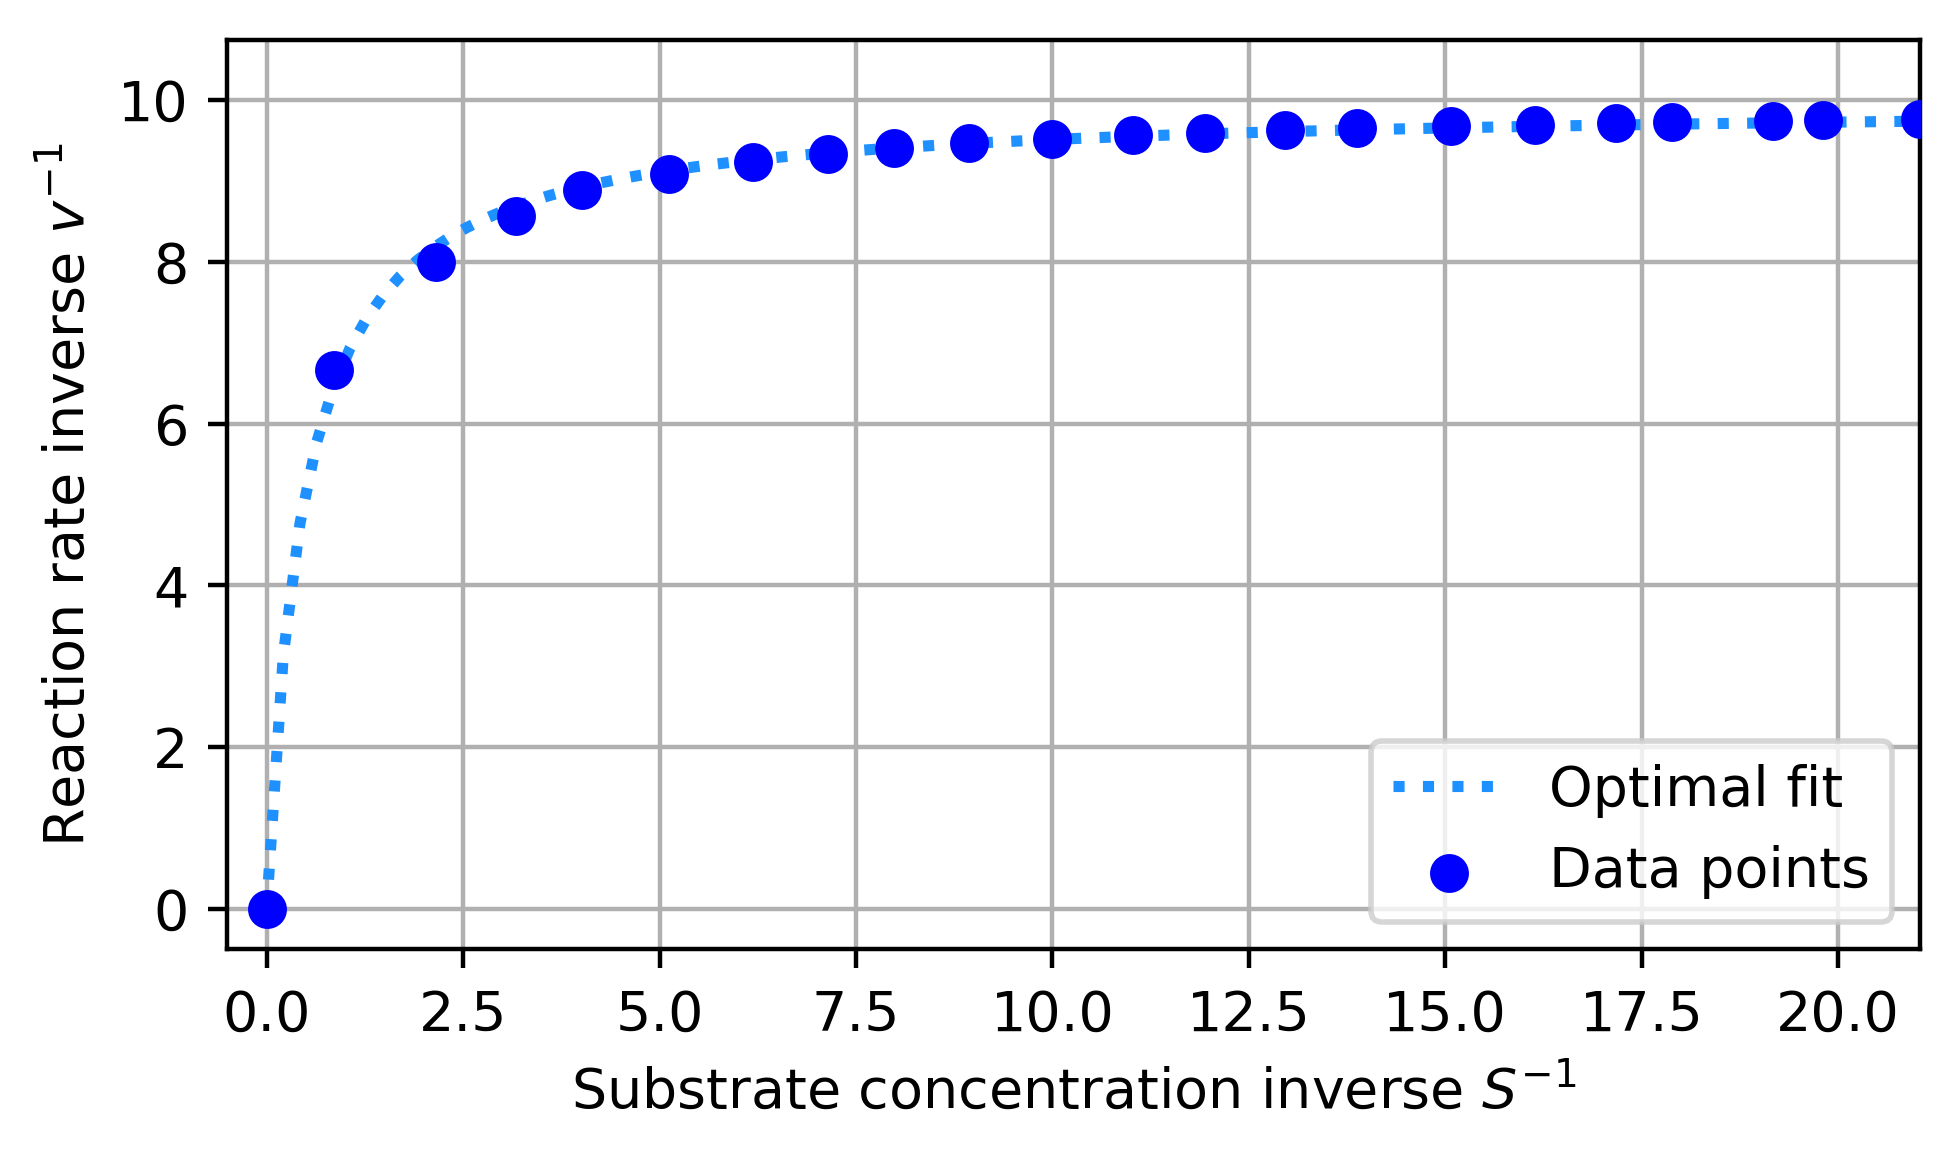

In [59]:
fig, ax = plt.subplots(1,1,figsize=FIG_SIZE, dpi=DPI, layout='tight')

ax.set_xlim((-0.5, max(ss)))
ax.set_ylim((-0.5, 1.1*max(vv)))


ax.set_xlabel(r"Substrate concentration inverse $S^{-1}$")
ax.set_ylabel(r"Reaction rate inverse $v^{-1}$")

ax.grid()

xxopt = np.linspace(min(ss), max(ss), 100)
ax.plot(xxopt, michaelis_menten_equation(xxopt, vmaxopt, kmopt), ls="dotted", lw=2.0,  color="dodgerblue", label="Optimal fit")

ax.scatter(ss, vv, color="blue", label="Data points", zorder=10)

ax.legend(loc="lower right")

print(f"Estimated Vmax = {np.round(vmaxopt, 2)}")
print(f"Estimated Km = {np.round(kmopt, 2)}")

plt.savefig("media/assignment1/fitted_model_from_dataset.png", bbox_inches="tight")
plt.show()

## Lineweaver-Burk plot

Estimated Vmax = 9.92
Estimated Km = 0.44


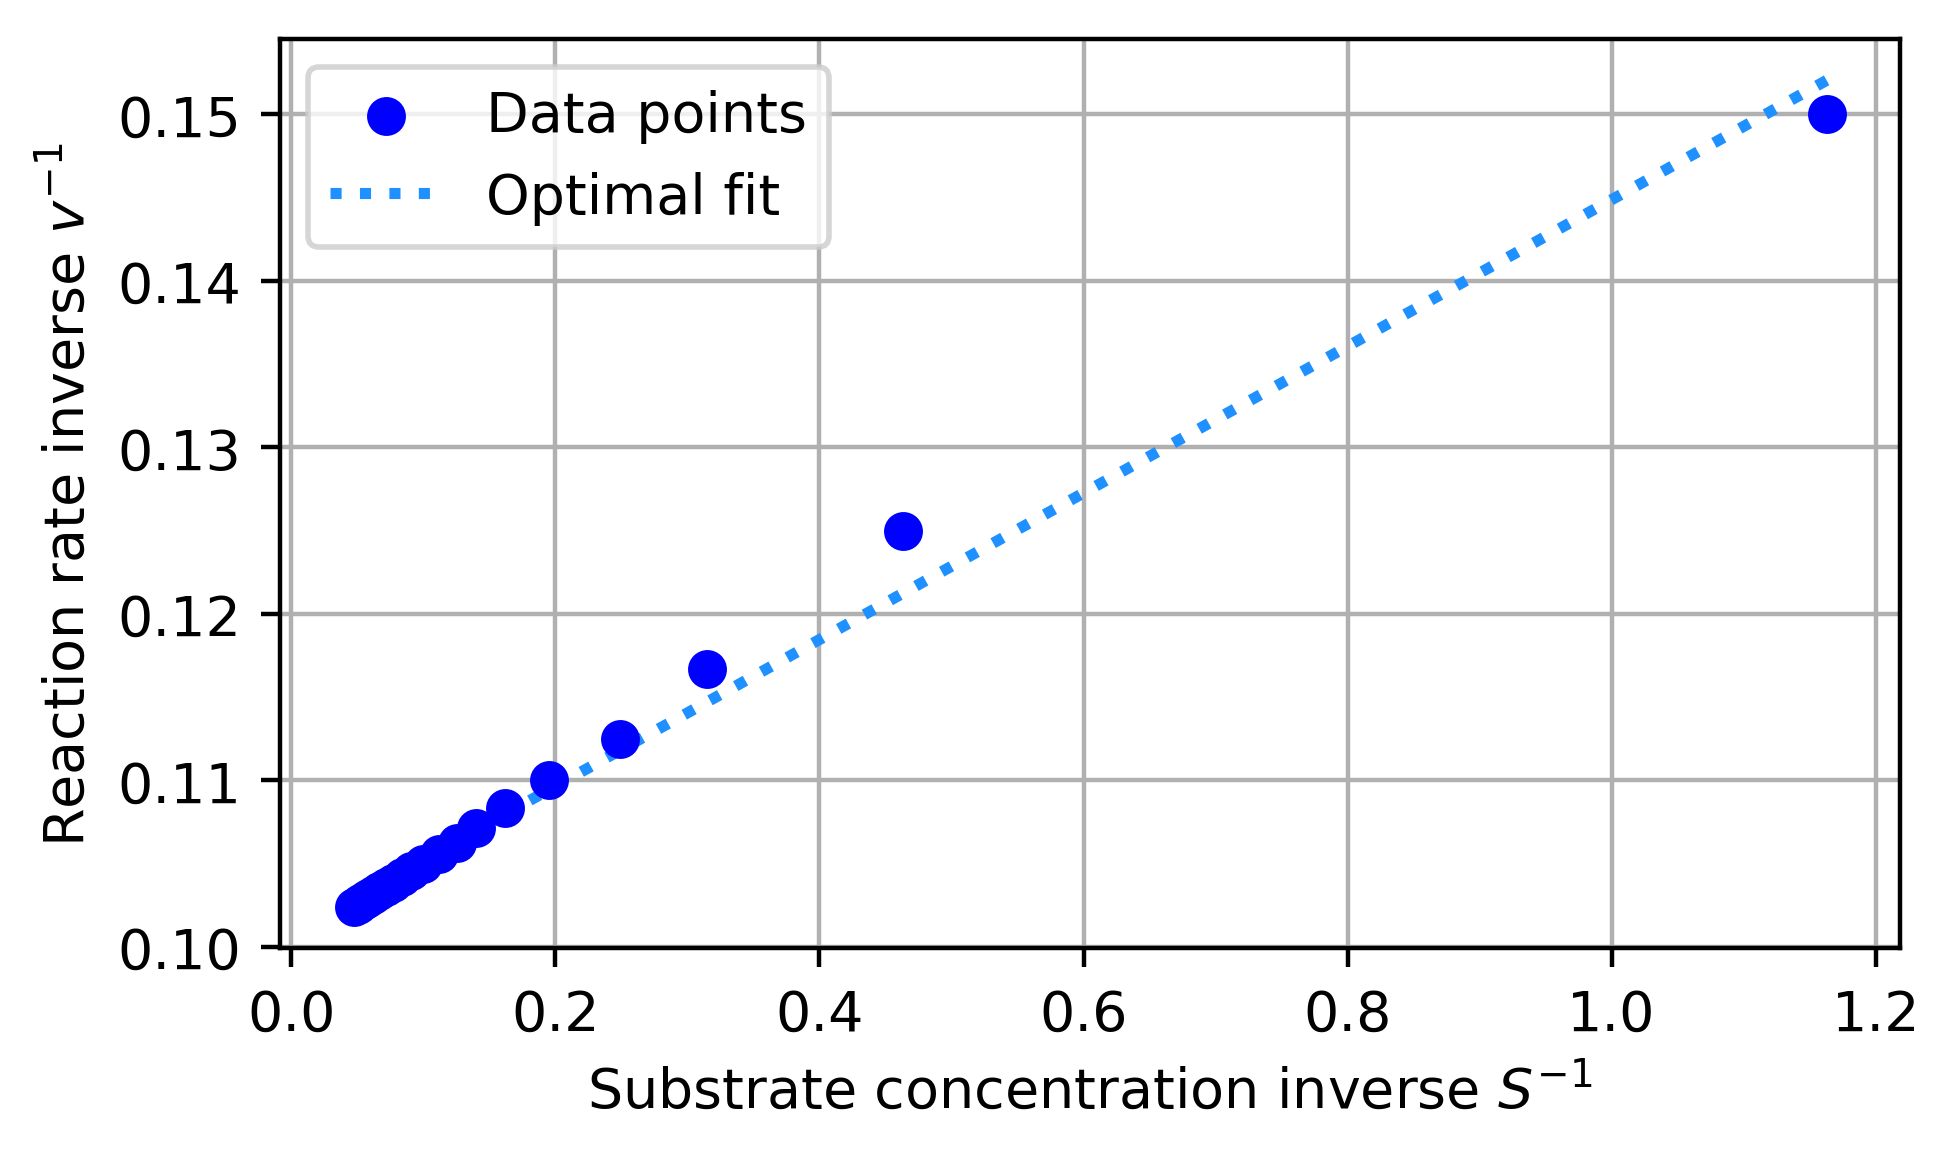

In [60]:
ssinv = 1 / ss[1:]
vvinv = 1 / vv[1:]

def linear_equation(sinv, a, b):
    return a + b * sinv

popt, _ = curve_fit(linear_equation, ssinv, vvinv)
a, b = popt

vmaxopt = 1 / a
kmopt = b / a

print(f"Estimated Vmax = {np.round(vmaxopt, 2)}")
print(f"Estimated Km = {np.round(kmopt, 2)}")

fig, ax = plt.subplots(1,1,figsize=FIG_SIZE, dpi=DPI, layout='tight')

ax.set_xlabel(r"Substrate concentration inverse $S^{-1}$")
ax.set_ylabel(r"Reaction rate inverse $v^{-1}$")

ax.grid()

ax.scatter(ssinv, vvinv, color="blue", zorder=10, label="Data points",)
ax.plot(ssinv, linear_equation(ssinv, a, b), ls="dotted", lw=2.0, color="dodgerblue", label="Optimal fit")

plt.legend()
plt.savefig("media/assignment1/lineweaver_burk.png", bbox_inches="tight")
plt.show()

## Inhibitors

In [61]:
def michaelis_menten_inhibition(substrate, inhibitor, km, vmax, ki, inhib_type):
    if inhib_type == 'competitive':
        return vmax * substrate / ((1 + inhibitor/ki) * km + substrate)
    elif inhib_type == 'uncompetitive':
        return vmax * substrate / (km + (1 + inhibitor/ki) * substrate)
    elif inhib_type == 'noncompetitive':
        return vmax * substrate / ((1 + inhibitor/ki) * (km + substrate))

In [62]:
km = 1
vmax = 12
substrate = np.linspace(0, 10, 100)
colors = ['tab:blue', 'tab:red', 'tab:green']
kis = [2, 5, 2]
inhibitors = [2, 2, 5]
inhib_types = ['competitive', 'uncompetitive', 'noncompetitive']

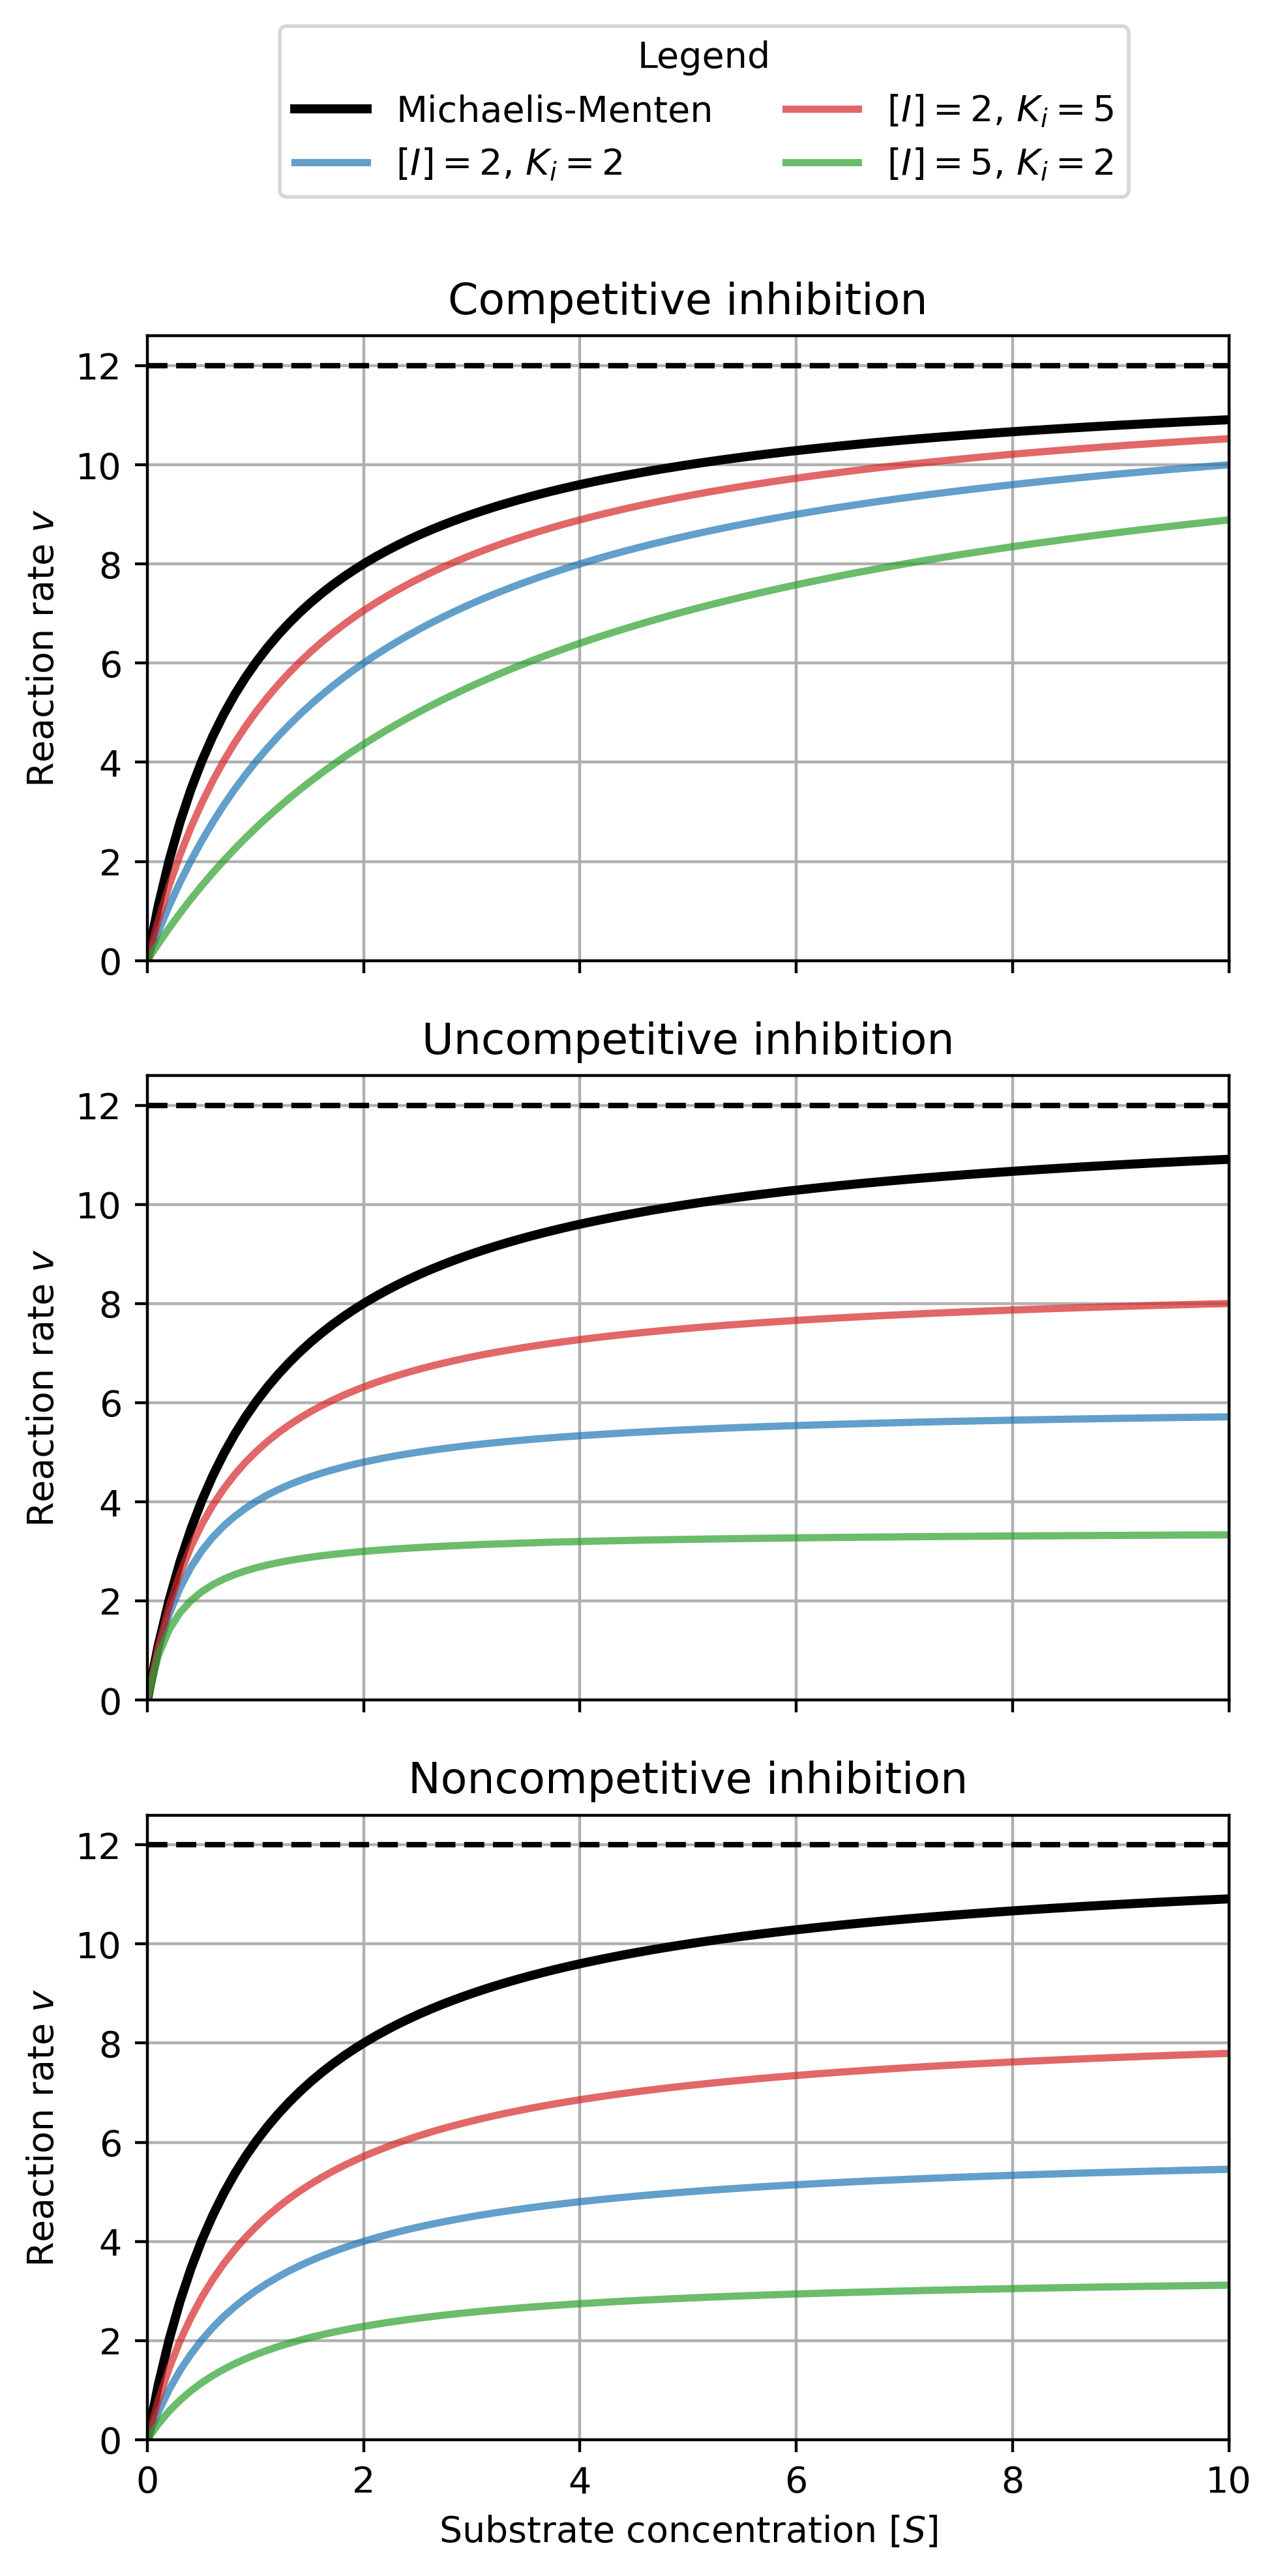

In [63]:
fig, axs = plt.subplots(3, 1, figsize=(FIG_SIZE[0], 3*FIG_SIZE[1]), sharex=True, layout='tight', dpi=DPI)
lines = []
labels = []
for i, (ax, inhib_type) in enumerate(zip(axs, inhib_types)):
    vs = michaelis_menten(substrate, km, vmax)
    ax.hlines(vmax, substrate[0], substrate[-1], linestyles="dashed", color='black')
    line, = ax.plot(substrate, vs, label="Michaelis-Menten", color="black", lw=2.5)
    if i == 0:
        lines.append(line)
        labels.append("Michaelis-Menten")
    ax.set_ylim((0, vmax * 1.05))
    ax.set_xlim((0, substrate[-1]))
    ax.set_ylabel("Reaction rate $v$")

    for inhib, ki, color in zip(inhibitors, kis, colors):
        vs = michaelis_menten_inhibition(substrate, inhib, km, vmax, ki, inhib_type)
        line, = ax.plot(substrate, vs, label=f"$[I]={inhib}$, $K_i={ki}$", color=color, lw=2, alpha=0.7)
        if i == 0:
            lines.append(line)
            labels.append(f"$[I]={inhib}$, $K_i={ki}$")
    ax.grid(True)
    ax.set_title(f"{inhib_type.capitalize()} inhibition")
axs[-1].set_xlabel("Substrate concentration $[S]$")

# Create a legend for the whole figure
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.55, 1.1), ncol=2, title='Legend')
fig.savefig(f'{MEDIA_PATH}/michaelis_menten_inhibition.png', bbox_inches='tight')
plt.show()

In [64]:
ss2, vv2 = np.genfromtxt("data/DataI2.csv", delimiter=",").T
ss5, vv5 = np.genfromtxt("data/DataI5.csv", delimiter=",").T
ss8, vv8 = np.genfromtxt("data/DataI8.csv", delimiter=",").T

xx = np.linspace(-0.05, 1.1, 1000)

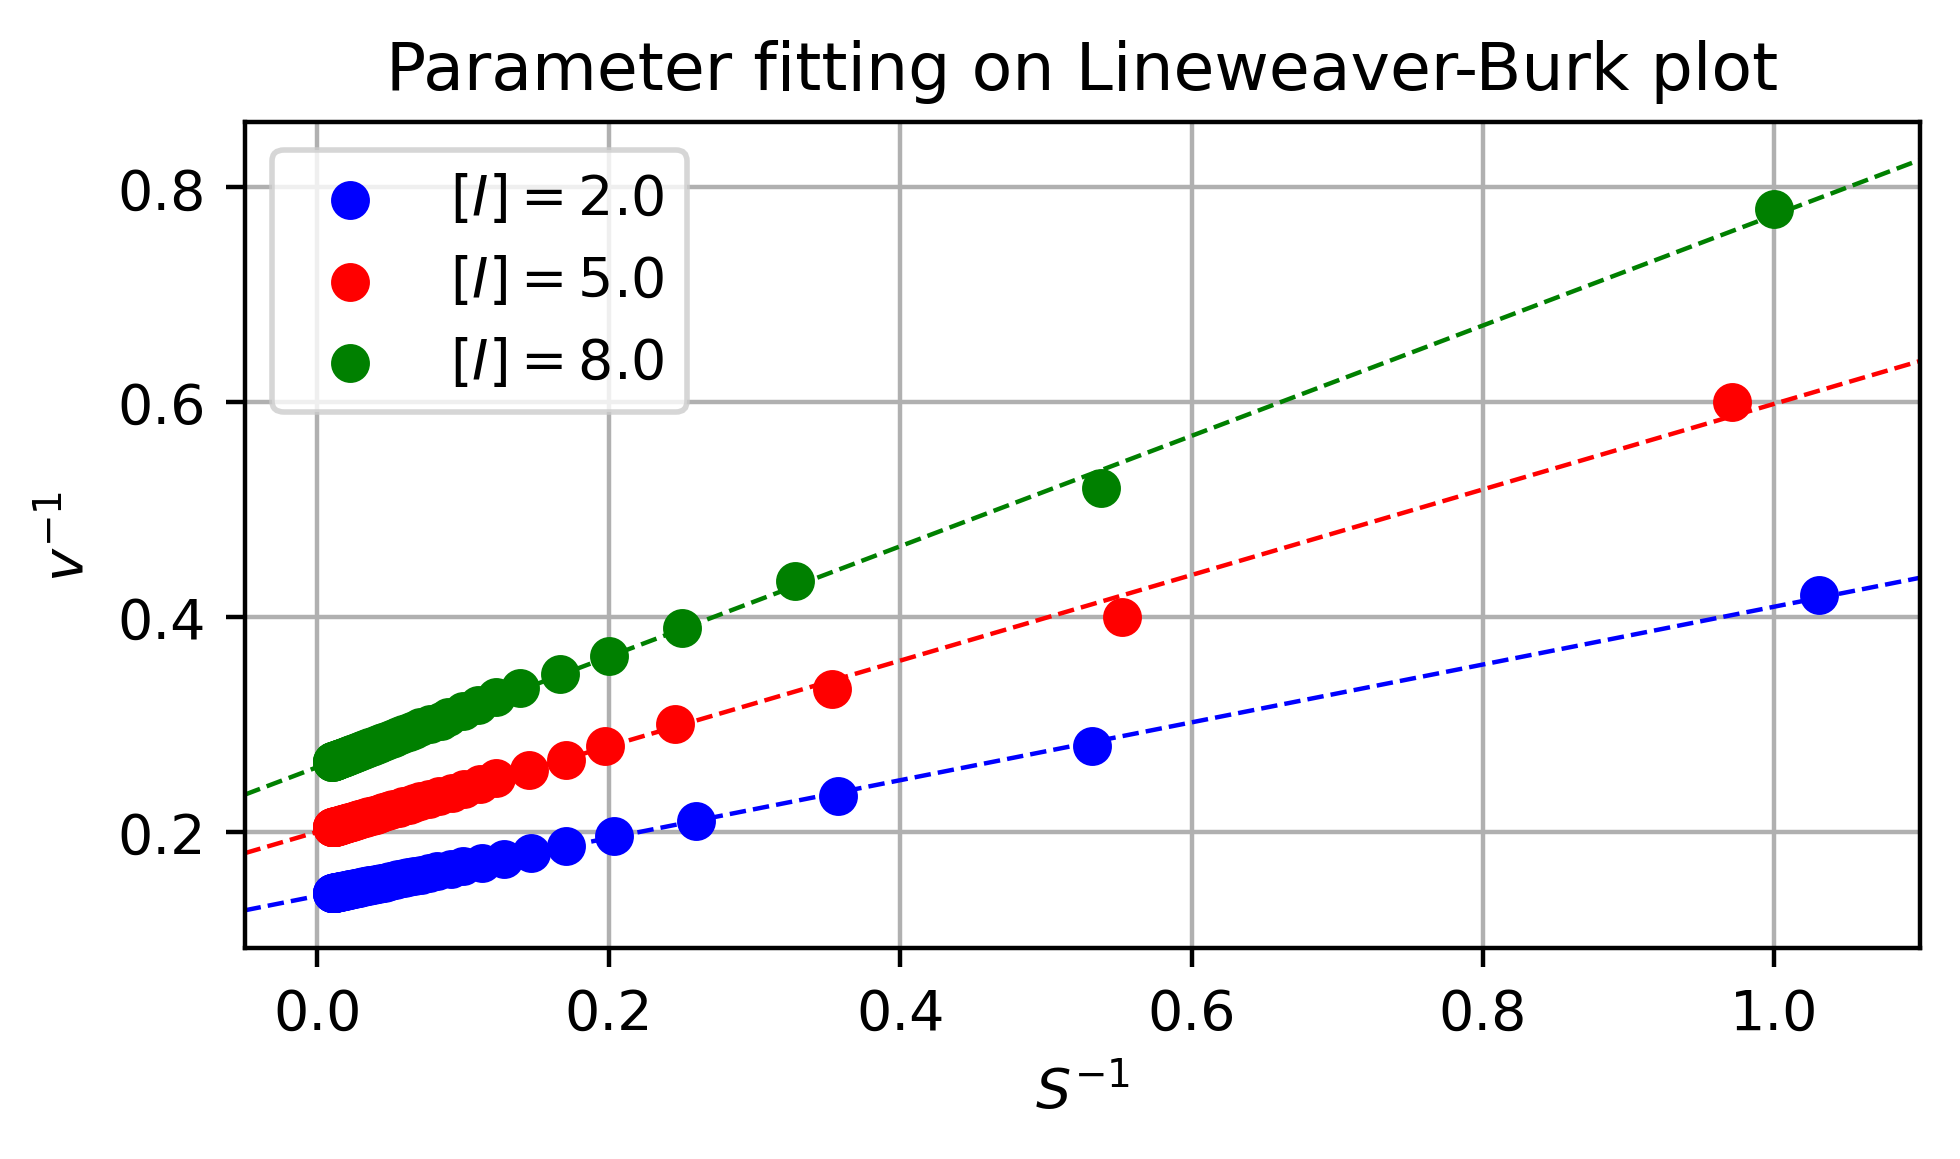

In [65]:
ssinv2, vvinv2 = 1 / ss2[1:], 1 / vv2[1:]
ssinv5, vvinv5 = 1 / ss5[1:], 1 / vv5[1:]
ssinv8, vvinv8 = 1 / ss8[1:], 1 / vv8[1:]

fig, ax = plt.subplots(1,1,figsize=FIG_SIZE, dpi=DPI, layout='tight')

ax.set_xlabel(r"$S^{-1}$")
ax.set_ylabel(r"$v^{-1}$")

ax.set_xlim((-0.05, 1.1))

ax.grid()

ax.scatter(ssinv2, vvinv2, color="blue", zorder=10, label=r"$[I]=2.0$")
popt2, _ = curve_fit(linear_equation, ssinv2, vvinv2)
a, b = popt2
ax.plot(xx, linear_equation(xx, a, b), ls="dashed", color="blue", lw=0.8)

ax.scatter(ssinv5, vvinv5, color="red", zorder=10, label=r"$[I]=5.0$")
popt5, _ = curve_fit(linear_equation, ssinv5, vvinv5)
a, b = popt5
ax.plot(xx, linear_equation(xx, a, b), ls="dashed", color="red", lw=0.8)

ax.scatter(ssinv8, vvinv8, color="green", zorder=10, label=r"$[I]=8.0$")
popt8, _ = curve_fit(linear_equation, ssinv8, vvinv8)
a, b = popt8
ax.plot(xx, linear_equation(xx, a, b), ls="dashed", color="green", lw=0.8)

ax.legend()
ax.set_title("Parameter fitting on Lineweaver-Burk plot")
fig.savefig(f'{MEDIA_PATH}/lineweaver_burk_inhibition.png', bbox_inches='tight')
plt.show()